# Python (Numba-compiled) NET-seq TASEP Simulation demonstration

This notebook runs the fast Python TASEP simulation for the **insQ** gene with 300 runs.

**Wallclock time comparison**: With an Intel(R) Core(TM) i7-10750H CPU, the numba Python script takes ~20s (including first compile time) to run 300 TASEP simulations for the insQ gene, while the MATLAB script takes ~900s.

With multithreading implemented (12 cores), the new script takes ~3s to finish 300 runs.

Note: The Numba JIT functions in netseq_tasep_fast.py are compiled on first call. This means the first run will take longer, but subsequent runs (even on a different gene or set of parameters) will now be faster as the function is now compiled on machine code.

## 1. Run the simulation

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from netseq_tasep_fast import (
    run_netseq_simulations_fast,
    netseq_tasep_fast,
    _load_gene_parameters,
    _compute_netseq_sum,
    SNAPSHOTS,
)

GENE = "insQ"
N_RUNS = 300
SEED = 42

In [14]:
# Run 300-run averaged simulation
netseq_avg = run_netseq_simulations_fast(GENE, n_runs=300, seed=SEED, n_workers=os.cpu_count())

print(f"Gene: {GENE}")
print(f"Gene length: {len(netseq_avg)} bp")
print(f"Runs: {N_RUNS}")
print(f"Snapshots: {SNAPSHOTS}")

Gene: insQ
Gene length: 1149 bp
Runs: 300
Snapshots: [200, 400, 600, 800, 1000, 1200, 1400]


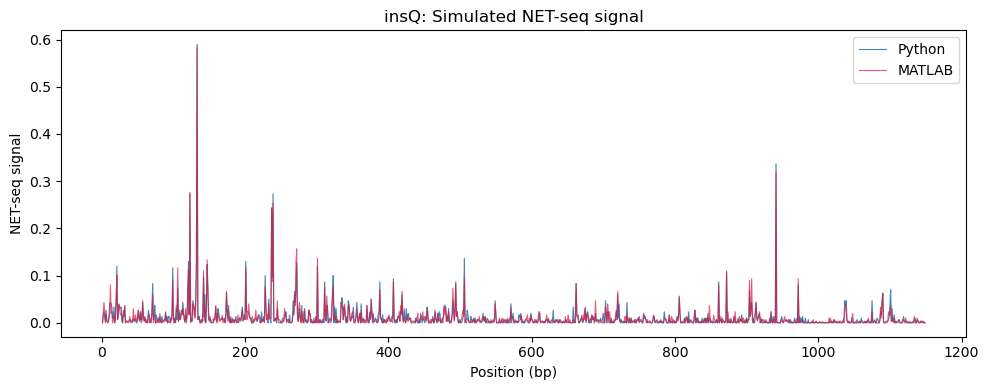

In [15]:
# Plot the averaged NET-seq signal: Python vs MATLAB
matlab_netseq = np.loadtxt("sample-results/insq-matlab.csv")
x = np.arange(1, len(netseq_avg) + 1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, netseq_avg, color="steelblue", lw=0.8, label="Python")
ax.plot(x, matlab_netseq, color="crimson", lw=0.8, alpha=0.7, label="MATLAB")
ax.set_xlabel("Position (bp)")
ax.set_ylabel("NET-seq signal")
ax.set_title(f"{GENE}: Simulated NET-seq signal")
ax.legend()
plt.tight_layout()
plt.show()

C:\Users\Ron\AppData\Local\Temp\ipykernel_28300\2947448649.py:9: RuntimeWarning: divide by zero encountered in divide
  (netseq_avg - matlab_netseq) * 100 / matlab_netseq,
C:\Users\Ron\AppData\Local\Temp\ipykernel_28300\2947448649.py:9: RuntimeWarning: invalid value encountered in divide
  (netseq_avg - matlab_netseq) * 100 / matlab_netseq,


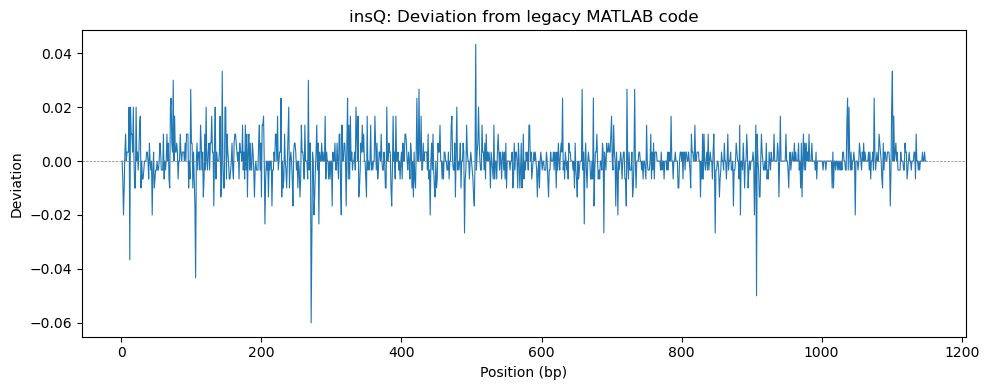

In [16]:
# Plot percent deviation: Python vs MATLAB
matlab_netseq = np.loadtxt("sample-results/insq-matlab.csv")
x = np.arange(1, len(netseq_avg) + 1)

# Percent deviation: 0/0 → 0% (both agree), nonzero/0 → NaN (shown as gap)
both_zero = (netseq_avg == 0) & (matlab_netseq == 0)
pct_dev = np.where(both_zero, 0.0,
                   np.where(matlab_netseq != 0,
                            (netseq_avg - matlab_netseq) * 100 / matlab_netseq,
                            np.nan))

fig, ax = plt.subplots(figsize=(10, 4))
# ax.plot(x, pct_dev, color="steelblue", lw=0.8)
ax.plot(x, (netseq_avg-matlab_netseq), lw=0.8)
ax.axhline(0, color="gray", ls="--", lw=0.5)
ax.set_xlabel("Position (bp)")
ax.set_ylabel("Deviation")
ax.set_title(f"{GENE}: Deviation from legacy MATLAB code")
plt.tight_layout()
plt.show()

## 2. Comparing averaging methods: Python vs MATLAB

### MATLAB approach (`NETSEQ_simulations.m`)

```matlab
final_output = sjkimlab_NETSEQ_TASEP(parameters);       % run #1
for i = 1:nloci                                          % runs #2 through #(nloci+1)
    output = sjkimlab_NETSEQ_TASEP(parameters);
    final_output.NETseq = final_output.NETseq + output.NETseq;
end
final_output.NETseq = final_output.NETseq / nloci;       % divides by nloci, not nloci+1
NETseqSum = sum(temp_NETseq(:, 200:200:1500), 2);        % sum 7 snapshot columns
```

**Key observations:**

1. **Full matrix storage**: Each run produces a `(geneLength, simtime)` matrix. All matrices are summed element-wise, then divided.
2. **Order of operations**: Average the full matrices first, *then* sum the 7 snapshot columns.
3. **Off-by-one**: The loop runs `nloci+1` total simulations (1 before the loop + `nloci` inside) but divides by `nloci`. For `nloci=300`, this averages 301 simulations divided by 300.

### Python approach (`netseq_tasep_fast.py`)

```python
# Per run: compute snapshot sum directly from exit times (no full matrix)
netseq_sum_i = _compute_netseq_sum(rnap_exit_matrix, n_rnap, gene_length, snapshots)

# Average: sum the per-run snapshot sums, divide by n_runs
netseq_avg = sum(netseq_sum_i for i in range(n_runs)) / n_runs
```

**Key observations:**

1. **No full matrix**: Never constructs the `(geneLength, simtime)` matrix. Instead, for each snapshot time, it finds each RNAP's position from the exit-time record and bins directly.
2. **Order of operations**: Sum snapshot columns per run first, *then* average across runs.
3. **Correct count**: Divides by exactly `n_runs`.

### Why these are mathematically equivalent

Let $M_i(x, t)$ be the NET-seq matrix for run $i$. The MATLAB result is:

$$\text{NETseqSum}(x) = \sum_{t \in T} \left[\frac{1}{N}\sum_{i=1}^{N} M_i(x,t)\right] = \frac{1}{N}\sum_{i=1}^{N}\sum_{t \in T} M_i(x,t)$$

which is the same as the Python result: average of per-run snapshot sums. The sum and average commute.

## Summary of differences

| Aspect | MATLAB (`NETSEQ_simulations.m`) | Python (`netseq_tasep_fast.py`) |
|---|---|---|
| **Storage per run** | Full `(L, simtime)` matrix | Only snapshot sum vector `(L,)` |
| **Memory** | ~L x 2000 floats per run | ~L floats per run |
| **Averaging order** | Average matrices, then sum snapshots | Sum snapshots, then average |
| **Snapshots** | `200:200:1500` = [200,400,...,1400] | `[200,400,...,1400]` |
| **Parallelism** | Sequential (single-threaded MATLAB) | Multi-process via `ThreadPoolExecutor` |
| **JIT compilation** | No (MATLAB interpreter) | Numba `@njit` for core loop |